In [71]:
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity, plot_2dsim
from tqdm import tqdm
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
X, y = generate_gaussian_parity(1000)
X_ood, y_ood = generate_gaussian_parity(1000, angle_params=np.pi/4)

<AxesSubplot: >

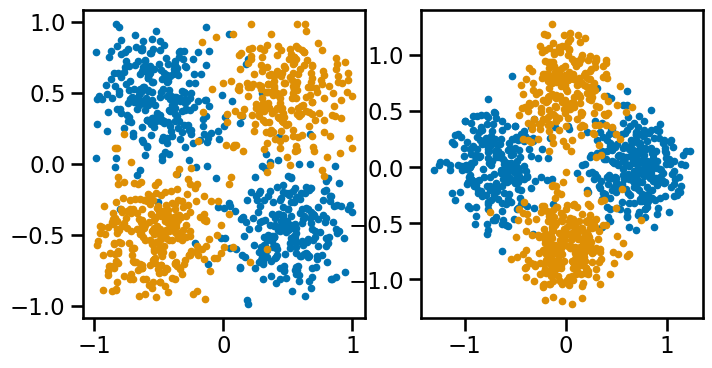

In [100]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

plot_2dsim(X,y, ax=ax[0])
plot_2dsim(X_ood,y_ood, ax=ax[1])

In [192]:
n_estimators = 500
n_seeds = 100
splitting_criteria = ['gini', 'entropy', 'log_loss']
n_criteria = len(splitting_criteria)
n_train_id = 1000
n_test_id = 1000
n_eval_ood = 1000
n_test_ood = 1000
angles = [0, np.pi/8, np.pi/4, np.pi/2]

In [212]:
def experiment(angle, n_components, stress=False):
    rf_models = [[] for _ in range(n_criteria)]

    x_train_id, y_train_id = generate_gaussian_parity(n_train_id)
    x_test_id, y_test_id = generate_gaussian_parity(n_test_id)
    
    x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=angle)
    x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=angle)
    
    for i in range(n_criteria):
        for j in range(n_seeds):
            model = rf(n_estimators=n_estimators, criterion=splitting_criteria[i], random_state=(j+1)*(i+1))
            model.fit(x_train_id, y_train_id)
            rf_models[i].append(model)

    ##########################################################
    l_id = np.zeros((n_criteria, n_seeds), dtype=float)
    l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
    proba = []
    
    for i in (range(n_criteria)):
        for j in range(n_seeds):
            proba.append(
                rf_models[i][j].predict_proba(x_eval_ood)
            )
            y_pred_id = rf_models[i][j].predict(x_test_id)
            y_pred_ood = rf_models[i][j].predict(x_test_ood)
            l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
            l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)

    ########################################################
    D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

    for ii in range(n_seeds*n_criteria):
        for jj in range(ii+1, n_seeds*n_criteria):
            D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
            D[jj,ii] = D[ii,jj]

    #######################################################

    embedding = MDS(n_components=n_components, dissimilarity='precomputed')
    X_transformed = embedding.fit_transform(D)

    if stress:
        return X_transformed, l_id, l_ood, embedding.stress_
    else:
        return X_transformed, l_id, l_ood

In [210]:
def plot_embeddings(X_transformed, l_id, l_ood, angle, ax):
    ax.scatter(X_transformed[:100,0], X_transformed[:100,1], l_ood[0], c='k', marker='o', alpha=(l_id[0]-np.min(l_id[0]))/(np.max(l_id[0])-np.min(l_id[0])), label=splitting_criteria[0], s=40)
    ax.scatter(X_transformed[100:200,0], X_transformed[100:200,1], l_ood[1], c='r', marker='o', alpha=(l_id[1]-np.min(l_id[1]))/(np.max(l_id[1])-np.min(l_id[1])), label=splitting_criteria[1], s=40)
    ax.scatter(X_transformed[200:,0], X_transformed[200:,1], l_ood[2], c='b', marker='o', alpha=(l_id[2]-np.min(l_id[2]))/(np.max(l_id[2])-np.min(l_id[2])), label=splitting_criteria[2], s=40)

    ax.set_zlabel('l_ood')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    ax.set_xticks([-0.5,0,0.5])
    ax.set_yticks([-0.5,0,0.5])
    

In [206]:
X_transformed, l_id, l_ood = [], [], []
for angle in tqdm(angles):
    X_, l_id_, l_ood_ = experiment(angle, 2)
    X_transformed.append(X_)
    l_id.append(l_id_)
    l_ood.append(l_ood_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [09:07<00:00, 136.85s/it]


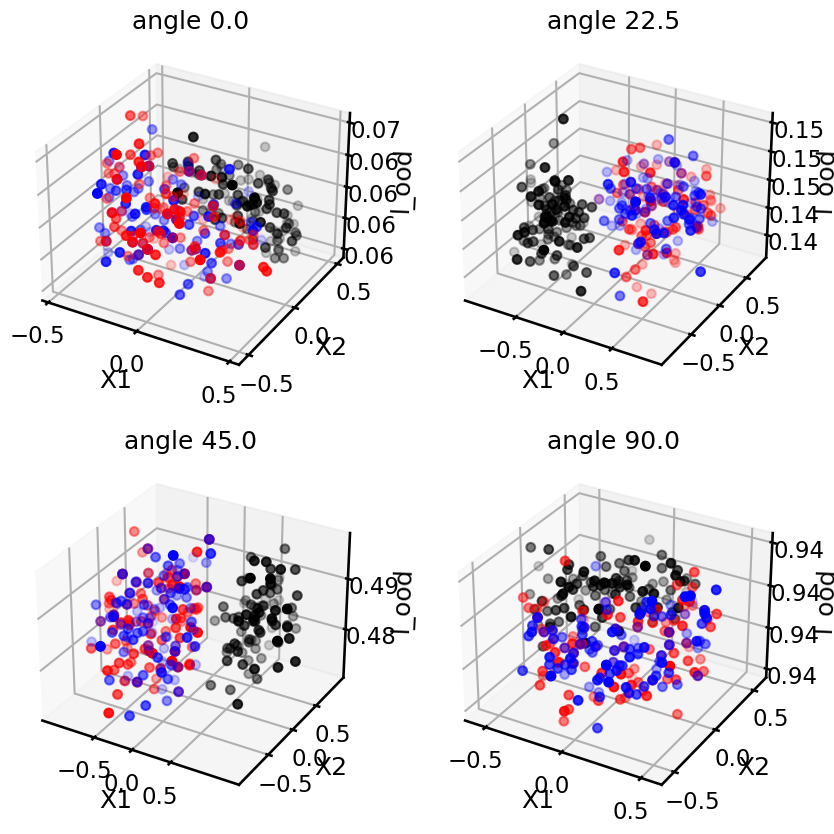

In [211]:
fig = plt.figure(figsize=(10,10))
sns.set_context('talk')

for ii, angle in enumerate(angles):
    ax = fig.add_subplot(2,2,ii+1, projection='3d')
    plot_embeddings(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax)

plt.savefig('embeddings.pdf')

In [218]:
n_components = [1,2,3,4,5,6,7,8,9,10]
stresses = []

for component in tqdm(n_components):
    _, _, _, stress = experiment(np.pi/4, component, stress=True)
    stresses.append(stress)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [22:52<00:00, 137.26s/it]


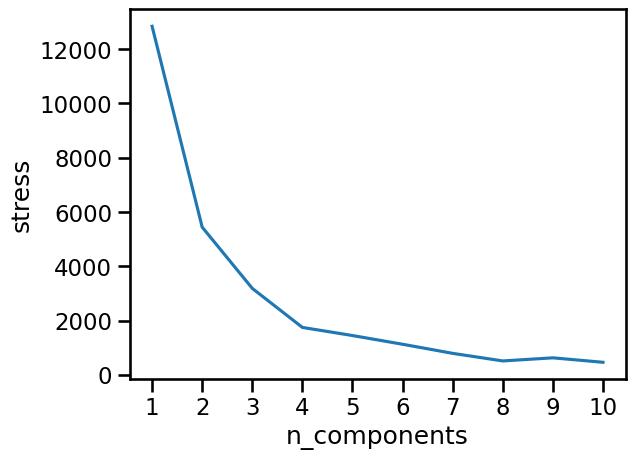

In [229]:
sns.set_context('talk')

plt.plot(n_components, stresses)
plt.xticks(n_components)
plt.xlabel('n_components')
plt.ylabel('stress')
plt.savefig('scree_plot.pdf', bbox_inches='tight')

In [230]:
import pickle

summary = (X_transformed, l_id, l_ood, stresses)

with open('result.pickle','wb') as f:
    pickle.dump(summary, f)